# Question 1

In [ ]:
# Question 1

# Question 2

## Import the relevant Libraries

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
from bs4 import BeautifulSoup
import ast
from urllib.request import Request, urlopen
from itertools import combinations 

## Get header from .name file and add to dataset

In [ ]:
dataset = pd.read_csv('house-votes-84.data',header=None)
soup_link2 = BeautifulSoup(open('house-votes-84.names'))
table_header = soup_link2.find('p')

def before(value, a):
    pos_a = value.find(a)
    if pos_a == -1: return ""
    return value[0:pos_a]

def after(value, a):
    pos_a = value.rfind(a)
    if pos_a == -1: return ""
    adjusted_pos_a = pos_a + len(a)
    if adjusted_pos_a >= len(value): return ""
    return value[adjusted_pos_a:]

header = after(table_header.text,"7. Attribute Information:\n")
header = before(header,"\n8. Missing Attribute Values: Denoted by")
list_header = []
for i in range(header.count('\n')):
    if(i<10):
        buffer = after(header," "+str(i+1)+". ")
    else:
        buffer = after(header,str(i+1)+". ")
    buffer = before(buffer,":")
    list_header.append(str(buffer))

dataset.columns = list_header
dataset.head()

In [ ]:
dataset.shape

##### There are 434 rows and 17 columns 

In [ ]:
dataset.describe(include = 'object')

#### From the table above, we can see the basic data structure of dataset: 
#### All columns is categorical data
#### First column "republican" have 2 unique value which is (republican and democrat)
#### 16 other columns have 3 unique value which are y, n and ? (while ? is the missing value)

## Checking for missing values

#### Missing values is fill with "?" in the dataset so we have to take care of it


In [ ]:
## replace "?" value to most frequent values in each columns
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values = "?" , strategy = 'most_frequent',verbose=0)
imputer = imputer.fit(dataset.iloc[:,1:])
dataset.iloc[:, 1:] = imputer.transform(dataset.iloc[:, 1:])
display(dataset.head())

#### So that all the missing value is fill with the most frequent values
#### Because there only 2 unique values for all columns so we don't need dummy variable

## Calculate Correlation Matrix of dataset to check correlations among columns 

#### Because all columns of the dataset have categorical values so that we’re can not simply use corr() function of Pandas dataframe. we're looking for other measure of association between two categorical features.
#### By using Cramér’s V correlation which based on a nominal variation of Pearson’s Chi-Square Test will help us to handle this scenario

In [ ]:
def cramers_v(confusion_matrix):
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

cols = list(dataset.columns)
corrM = np.zeros((len(cols),len(cols)))
for col1, col2 in combinations(cols, 2):
    idx1, idx2 = cols.index(col1), cols.index(col2)
    corrM[idx1, idx2] = cramers_v(pd.crosstab(dataset[col1], dataset[col2]))
    corrM[idx2, idx1] = corrM[idx1, idx2]

corr = pd.DataFrame(corrM, index=cols, columns=cols)

## Visualize Correlation Matrix of dataset by heat map

In [ ]:
sns.set(font_scale=2)
fig, ax = plt.subplots(figsize=(30, 30))
ax = sns.heatmap(corr, annot=True, ax=ax); ax.set_title("Cramer V Correlation between Variables");

## Selecting features based on correlation

#### We compare the correlation between features and remove one of two features that have a correlation higher than 0.9

In [ ]:
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
                selected_columns = dataset.columns[columns]
                new_dataset = dataset[selected_columns]
remove_columns = (list(set(dataset.columns) - set(new_dataset.columns)))
print(str(len(remove_columns))+" column removed which is: "+str(remove_columns))

#### Now dataset has only those columns with correlation less than 0.9

In [ ]:
display(new_dataset.head())

## Calculate distribution of selected features

#### We create new distribution dataframe for calculating

In [ ]:
buffer = pd.crosstab(index = new_dataset["Class Name"],columns=new_dataset["handicapped-infants"])
buffer = buffer.stack()
buffer.index = ['_'.join(idx) for idx in buffer.index]
buffer.name = "handicapped-infants"
distribution = pd.DataFrame(buffer)
for col in new_dataset.columns:
    if (col == "Class Name") or (col == "handicapped-infants"):
        pass
    else:
        buffer = pd.crosstab(index = new_dataset["Class Name"],columns=new_dataset[col])
        buffer = buffer.stack()
        buffer.index = ['_'.join(idx) for idx in buffer.index]
        distribution[col] = buffer.values 
display(distribution)

## Plotting the data to visualize their distribution

#### Using stacked bar to plot distribution

In [ ]:
sns.set(font_scale=1.5)
distribution.T.plot(kind='bar', stacked=True,figsize=(20,8),label='big')

# Question 3

#### Import libraries

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
# Import here

#### Encode the dataset

In [ ]:
lb = LabelBinarizer()
oe = LabelEncoder()
training_dataset = dataset.copy()
dataset_features = training_dataset.drop(columns='Class Name')
dataset_classname = training_dataset['Class Name']
X = dataset_features.copy()
for col in X:
    X[col] = oe.fit_transform(X[col])
Y = lb.fit_transform(dataset_classname)

## Decision Tree C4.5

In [ ]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from graphviz import Source

dtModel = DecisionTreeClassifier(criterion="entropy")
dtModel.fit(X, Y)

tree = export_graphviz(dtModel, out_file=None, label='root', feature_names=dataset_features.columns, class_names=lb.classes_, proportion=True, filled=True)
s = Source(tree, format="png")
s.view()

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(dtModel, X, Y, cv=10, scoring="f1").mean()

## Naive Bayes

In machine learning, Naïve Bayes classifiers are a family of simple "probabilistic classifiers" based on applying Bayes' theorem with strong (naïve) independence assumptions between the features  
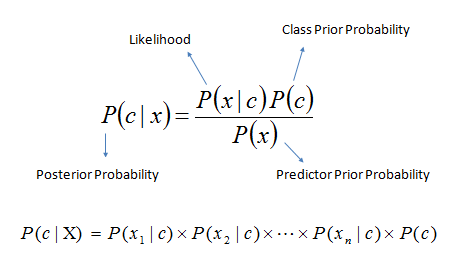

For example, we want to predict Class Name based on 2 features called "handicapped-infants" and "water-project-cost-sharing"  

| Likelihood Table    |     | Class name      |                 |                 |
|---------------------|-----|-----------------|-----------------|-----------------|
|                     |     | **Democrat**        | **Republican**      |                 |
| **handicapped-infants** | **Yes** | 156/267 = 0.584 | 31/168 = 0.184  | 187/435 = 0.430 |
|                     | **No**  | 111/267 = 0.416 | 137/168 = 0.815 | 248/435 = 0.570 |
|                     |     | 267/435 = 0.613 | 168/435 = 0.386 |                 |

**P(Democrat | handicapped-infants) = P(handicapped-infants | Democrat) * P(Democrat) / P(handicapped-infants) = 0.584\*0.613/0.430 = 0.833**  
Similarly, **P(Republican | handicapped-infants) = 0.184\*0.386/0.43 = 0.167**  

| Likelihood Table           |     | Class name      |                 |                 |
|----------------------------|-----|-----------------|-----------------|-----------------|
|                            |     | **Democrat**        | **Republican**      |                 |
| **water-project-cost-sharing** | **Yes** | 148/267 = 0.554 | 95/168 = 0.565  | 243/435 = 0.557 |
|                            | **No**  | 119/267 = 0.446 | 73/168 = 0.434  | 192/435 = 0.441 |
|                            |     | 267/435 = 0.613 | 168/435 = 0.386 |                 |

**P(Democrat | water-project-cost-sharing) = P(water-project-cost-sharing | Democrat) * P(Democrat) / P(water-project-cost-sharing) =0.554\*0.613/0.557 = 0.594**  
Similarly, **P(Republican | water-project-cost-sharing) = 0.565\*0.386/0.430 = 0.406**

Assume we have data record as below:

| handicapped-infants | water-project-cost-sharing |  | Class name |
|---------------------|----------------------------|--|------------|
| Yes                 | Yes                        |  | ?          |

**Likelihood of Democrat = P(handicapped-infants | Democrat) * P(water-project-cost-sharing | Democrat) = 0.584\*0.554 = 0.324**  
**Likelihood of Republican = P(handicapped-infants | Republican) * P(water-project-cost-sharing | Republican) = 0.184\*0.565 = 0.104**  
Hence, **P(Democrat) = 0.324/(0.324+0.104) = 0.757**  
Hence, **P(Republican) = 0.104/(0.324+0.104) = 0.234**  
This prediction can be simply understood as "If one person support handicapped-infants and water-project-cost-sharing, he has 75.7% is in Democrat and 23.4%"

=====
In scikit-learn, the algorithm uses more complicated likelihood calculating formular  
GaussianNB implements the Gaussian Naive Bayes algorithm for classification. The likelihood of the features is assumed to be Gaussian:  
$$P(x_i \mid y) = \frac{1}{\sqrt{2\pi\sigma^2_y}} \exp\left(-\frac{(x_i - \mu_y)^2}{2\sigma^2_y}\right)$$ 
The parameters **𝜎_y** and **𝜇_y** are estimated using maximum likelihood.  

#### Create classifier

In [ ]:
# Naive Bayes classifier can be found in sklearn.naive_bayes
from sklearn.naive_bayes import GaussianNB

nbModel = GaussianNB()
cross_val_score(nbModel, X, Y, cv=10).mean()

## ZeroR

In ZeroR, the algorithm finds most frequent class name and return that prediction constantly   
Because the dataset has 267 'democrat' records and 168 'republican' records  
The accuracy of this ZeroR model should be **Acc = (267)/(267+168) ≈ 0.6138**

In [ ]:
# ZeroR classifier (DummyClassifier) can be found in sklearn.dummy packages
from sklearn.dummy import DummyClassifier
zeroRModel = DummyClassifier(strategy='most_frequent')

zeroRModel.fit(X, dataset_classname)
print("ZeroR accuracy:", zeroRModel.score(X, dataset_classname))

# Question 4

#### Precision and Recall

<blockquote>Precision and recall are measurements for the accuracy of information retrieval, classification, and identification within a computer program.</blockquote>
<blockquote>Precision, or the positive predictive value, refers to the fraction of relevant instances among the total retrieved instances.</blockquote>
<blockquote>Recall, also known as sensitivity, refers to the fraction of relevant instances retrieved over the total amount of relevant instances. In short, precision and recall are measurements of relevance.</blockquote>
<blockquote>In some cases, precision and recall are measured together in what is known as the F-score, or F-measure. The F-score is the harmonic average of the precision and recall measurements</blockquote>

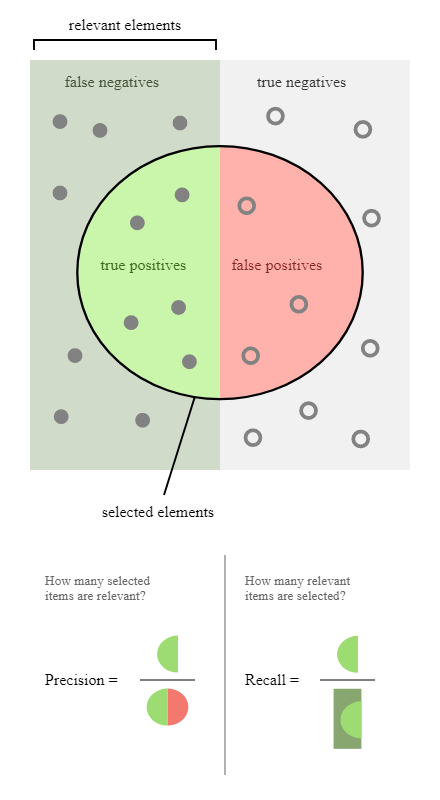

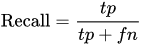
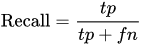

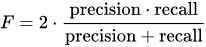

In [ ]:
import numpy as np
from sklearn import svm
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import precision_score, recall_score

def calc_precision_recall_f1(model, x, y, K=10):
    skf = KFold(n_splits=K, shuffle=True)
    precision_scores = []
    recall_scores = []
    f1_scores = []
    for train_index, test_index in skf.split(x, y):
        X_train, X_test = x.iloc[train_index], x.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = 2 * (precision * recall) / (precision + recall)
        
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)
    
    return precision_scores, recall_scores, f1_scores

#### Naive Bayes Classifier

In [ ]:
_,_,nbF1 = calc_precision_recall_f1(nbModel, X, Y)    #Precicion and Recall for Naive Bayes Classfier
print('F_measure value for Naive Bayes Classifier: ')
np.mean(nbF1)

#### Decision Tree Classifier

In [ ]:
_,_,dtF1 = calc_precision_recall_f1(dtModel, X, Y)    #Precicion and Recall for Naive Bayes Classfier
print('F_measure for Decision Tree Classifier: ')
np.mean(dtF1)

With the above result, we can see that the F_measure value of Decision Tree Classifier is slightly higher than F_measure value of Naive Bayes Classifier, which proves that: with our dataset, Decision Tree Classifier is more effective than Naive Bayes Classifier

# END